## Clustering sur les circonscriptions

In [154]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    pairwise_distances_argmin_min,
    davies_bouldin_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# from umap import UMAP
import seaborn as sns
import random

random.seed(31)

Nous avons 566 circonscriptions dans la base de données décrites par 122 variables au format numérique. Il y a 62 variables qui ont des valeurs manquantes. Le maximum des valeurs manquantes étant atteint pour la variable Part des maisons chauffées au fioul (avec 27 valeurs manquantes, notemment pour les circonscriptions à partir d'Outre-Mer). Au sein des communes métropolitaines, il reste les variables iranr_dep (part des individus travaillant dans un autre département les années précédentes) et lit_dep qui ont 18 valeurs manquantes (dans les arrondissements de Paris). On les impute par la moyenne. 

In [89]:
from datacirco import utilitaires

df = pd.read_excel(
    "../data/revenu/indic-stat-circonscriptions-legislatives-2022.xlsx",
    header=7,
    na_values=["nd", ""],
    sheet_name="indicateurs_circonscriptions",
).drop(0)
df["circo"] = df["circo"].apply(utilitaires.get_str_circo)

In [90]:
df_nona = df.loc[df["circo"].apply(lambda x: x[0]) == "0"]
df_nona.iloc[:, 2:124] = df_nona.iloc[:, 2:124].apply(lambda x: x.fillna(x.median()))
# pd.DataFrame(df_nona.isna().sum()).loc[df_nona.isna().sum() > 0]
# On normalise les données :
scaler = StandardScaler()
df_normalise = scaler.fit_transform(df_nona.iloc[:, 2:124])

In [91]:
# On vérifie que le dataframe soit bien normalisé :
print(np.mean(df_normalise, axis=0)[:2])
print(np.std(df_normalise, axis=0, ddof=0)[:2])
print(len(df_normalise))

[3.29565276e-16 6.59130553e-17]
[1. 1.]
539


In [99]:
df_stock_cluster = df_nona.iloc[:, :2]

df_normalise est un array qui contient 539 lignes (autant que de circonscriptions) de 122 coordonnées.

## Clustering sans réduction de dimension

In [137]:
# si on ne souhaite garder que certaines variables :
# scaler = StandardScaler()
# df_normalise = scaler.fit_transform(df_nona[variables_gardees])

In [120]:
# quand on veut réutiliser les résultats de l'ACP
# df_normalise = df_test_ACP.iloc[:, 1:]
# df_normalise.head(2)

population_1  population_2  population_3  population_4  type_ville_1  \
1      0.424814      0.998192      0.330840      0.424814     -1.970240   
2      1.928527      0.399115      0.347283      1.928527     -0.959865   

   type_ville_2  type_ville_3  type_ville_4     age_1     age_2  ...  \
1     -1.716437      1.636951     -1.970240 -0.041408 -0.455931  ...   
2     -2.029981     -0.982994     -0.959865 -1.896241 -0.562071  ...   

   revenu_pauvrete_3  revenu_pauvrete_4  composition_revenu_1  \
1           0.120030          -1.575413              0.374346   
2          -0.046341          -4.934070             -1.260306   

   composition_revenu_2  composition_revenu_3  composition_revenu_4  \
1              0.148656             -0.288106              0.374346   
2             -0.223535             -0.353330             -1.260306   

   eloignement_services_1  eloignement_services_2  eloignement_services_3  \
1               -1.981722                0.973245                0.563728   
2               -1.085522                1.377527                0.406351   

   eloignement_services_4  
1               -1.981722  
2               -1.085522  

[2 rows x 60 columns]

In [138]:
df_normalise

array([[-0.70110907, -0.90254777, -0.60880756, ..., -0.23315966,
        -0.68318229,  0.30896283],
       [ 0.84150339, -1.42903397, -0.13792787, ..., -0.82506873,
        -0.98650622,  1.7139581 ],
       [ 0.86263506, -0.22563694,  0.71604038, ..., -0.04482496,
         0.02457355,  0.89437753],
       ...,
       [ 1.73959968,  1.95552016, -0.82429488, ...,  2.13447663,
         3.36113681,  2.53353867],
       [ 1.00527389,  0.15042463, -0.58486453, ...,  1.08518327,
         1.13676131,  2.33840044],
       [ 1.43319036,  0.37606157,  0.2531417 , ...,  0.70851386,
         1.13676131,  2.18228986]])

In [139]:
# On applique la méthode du coude pour savoir combien de partitions faire :
inerties = []
silhouettes = []
K = range(2, 12)
for k in K:
    kmeansmodel = KMeans(n_clusters=k, random_state=31)
    # les données doivent être normalisées car on calcule des distances
    kmeansmodel.fit(df_normalise)
    inerties.append(kmeansmodel.inertia_)
    silhouettes.append(silhouette_score(df_normalise, kmeansmodel.labels_))

Text(0.5, 1.0, 'Inertie en fonction du nombre de groupes')

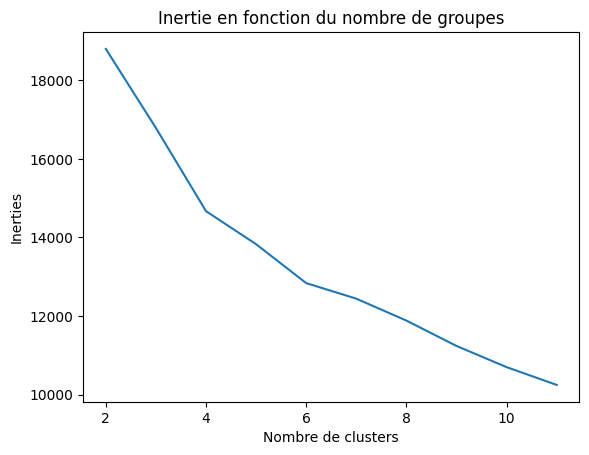

In [140]:
plt.plot(range(2, 12), inerties)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inerties")
plt.title("Inertie en fonction du nombre de groupes")

Le score de silhouette montre la sitinction entre les groupes : optimal pour k = 5

In [141]:
# Graphique du score de la silhouette :
plt.figure(figsize=(10, 4))
plt.plot(K, silhouettes, "bx-")
plt.xlabel("k")
plt.ylabel("Score de silhouette")

Text(0, 0.5, 'Score de silhouette')

In [145]:
kmeans = KMeans(n_clusters=6, random_state=31)
# kmeans a pour parametre init : si une liste est entrée, elle doit e^tre de type (n_clusters, n_features) et donner les centres initiaux.
kmeans.fit(df_normalise)
df_nona["cluster_labels"] = kmeans.labels_

/tmp/ipykernel_1017567/3936089922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nona['cluster_labels'] = kmeans.labels_


In [143]:
df_stock_cluster["cluster_labels_4_ACP"] = kmeans.labels_

In [146]:
cluster_centers = kmeans.cluster_centers_
# Calcul de la distance entre chaque point de données et les centres de clusters
closest, _ = pairwise_distances_argmin_min(cluster_centers, df_normalise)

# Affichage des indices des points de données les plus proches de chaque centre de cluster
print("Indices des points de données les plus proches des centres de clusters :")
print(closest)

# Les points du DataFrame les plus proches des centres de clusters
print("Points correspondants dans le DataFrame :")
print(df_nona["Nom de la circonscription"].iloc[closest])

Indices des points de données les plus proches des centres de clusters :
[187 489 228  58 396  72]
Points correspondants dans le DataFrame :
188                Isère  - 9e circonscription
490              Essonne  - 7e circonscription
229    Maine-et-Loire    - 1re circonscription
59     Bouches-du-Rhône  - 16e circonscription
397               Paris  - 12e circonscription
73     Charente-Maritime  - 3e circonscription
Name: Nom de la circonscription, dtype: object


In [75]:
# On importe les géometries des circonscriptions pour afficher une carte :
from datacirco.connexion_db import db

gdf_circo = gpd.read_postgis(
    sql="SELECT ref, ST_GeomFromWKB(wkb_geometry) as geom FROM zone_circo;",
    con=db.connection,
)

/datacirco/.venv/lib/python3.11/site-packages/geopandas/io/sql.py:158: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [166]:
palette_rouge = ["#ff0000", "#cc0033", "#990066", "#660099", "#3300cc", "#0000ff"]
palette_rose = ["#AA1945", "#EF3A5D", "#EBDDD7", "#2E2C2B", "#C6B79B", "#764640"]
cmap = ListedColormap(palette_rose)

In [167]:
gdf_cluster = gdf_circo.merge(df_nona, left_on="ref", right_on="circo")
gdf_cluster.plot(column="cluster_labels", legend=True, cmap=cmap)

<Axes: >

In [41]:
df_nona.iloc[:, 2:].groupby("cluster_labels").mean()[
    [
        "pop_légal_19",
        "tvar_pop",
        "pop_rur_non_periu",
        "pop_horsaav",
        "pop_urb",
        "age_moyen",
        "dec75",
        "actcho",
        "inactaut",
        "inactret",
        "inactetu",
        "actdip_PEU",
        "actdip_BAC",
        "actdip_BAC3",
        "act_cad",
        "act_agr",
        "act_ouv",
        "log_sec",
        "locatai",
        "ach90",
        "gratuit",
        "men_seul",
        "men_coupse",
        "men_monop",
        "iranr_dep",
        "iranr_fra",
        "iranr_etr",
        "ilt_com",
        "ilt_fra",
        "ilt_etr",
        "modtrans_pied",
        "modtrans_voit",
        "modtrans_commun",
        "tx_pauvrete60_diff",
        "nivvie_median_diff",
        "PPAT",
        "PPSOC",
        "acc_medecin",
        "acc_college",
    ]
]

pop_légal_19  tvar_pop  pop_rur_non_periu  pop_horsaav  \
cluster_labels                                                            
0               125402.741379  0.478736          11.950000     6.237356   
1               128921.375000  0.698438           0.217188     0.093750   
2               108928.609756 -0.013415          36.233537    16.839634   
3               125739.565789  0.459211           1.423684     0.632895   
4               124675.803279  0.252459           0.100000     0.075410   

                  pop_urb  age_moyen      dec75    actcho  inactaut  \
cluster_labels                                                        
0               57.762644  41.244253  60.206897  5.386782  5.292529   
1               96.326562  38.398438  55.859375  5.487500  5.065625   
2               36.194512  44.842683  64.560976  5.643902  5.932317   
3               93.381579  38.722368  57.236842  8.010526  8.986842   
4               96.293443  39.155738  56.540984  6.739344  5.614754   

                 inactret  ...   ilt_etr  modtrans_pied  modtrans_voit  \
cluster_labels             ...                                           
0               23.045402  ...  2.652299       4.656897      81.354023   
1               17.228125  ...  1.829688       5.417187      54.554688   
2               29.163415  ...  0.844512       6.173171      82.588415   
3               18.982895  ...  1.375000       6.431579      64.910526   
4               17.762295  ...  0.534426      10.695082      40.113115   

                modtrans_commun  tx_pauvrete60_diff  nivvie_median_diff  \
cluster_labels                                                            
0                      6.899425           11.482759        22660.804598   
1                     32.210938           11.759375        25756.718750   
2                      2.808537           14.409756        20906.463415   
3                     21.782895           23.222368        19117.500000   
4                     36.104918           16.096721        24997.377049   

                     PPAT      PPSOC  acc_medecin  acc_college  
cluster_labels                                                  
0                9.744253   5.299425    79.039655    54.440230  
1                9.173438   4.482812    96.832813    88.784375  
2                9.807927   6.069512    67.600610    46.260976  
3                6.761842  10.061842    95.811842    86.515789  
4               12.790164   5.480328    98.550820    93.368852  

[5 rows x 39 columns]

On évalue les caractéristiques du clustering : 

In [72]:
# Calcul du SSE
sum = 0
# for i in range(len(df_normalise)) :
#     sum = sum + (math.dist(df_normalise[i], df_normalise[closest[kmeans.labels_[i]]]))**2
print("Critère d'inertie : ", kmeans.inertia_)
print("Critère silhouette : ", silhouette_score(df_normalise, kmeans.labels_))
print(
    "Critère de David-Bouldin : ",
    davies_bouldin_score(X=df_normalise, labels=kmeans.labels_),
)
# print("SSE :", sum )

Critère d'inertie :  48054.217621992306
Critère silhouette :  0.2214785586192016
Critère de David-Bouldin :  1.4105435330485663


Text(0.5, 1.0, 'Relation entre le nombre de cadres et de diplomés BAC+5')

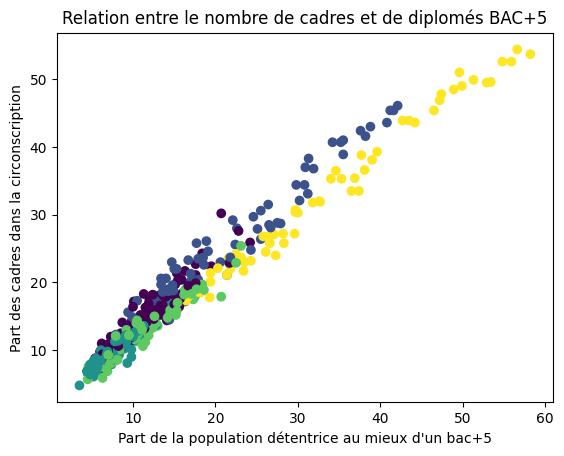

In [97]:
# On tente une rapide régression linéaire pour voir si il y a un lien entre la part de la population détentrice au mieux d'un bac+5 et la part des cadres dans la circonscription.
plt.scatter(
    df_nona["actdip_BAC5"].values,
    df_nona["act_cad"].values,
    c=df_nona["cluster_labels"].values,
)
plt.xlabel("Part de la population détentrice au mieux d'un bac+5")
plt.ylabel("Part des cadres dans la circonscription")
plt.title("Relation entre le nombre de cadres et de diplomés BAC+5")
# plt.legend(title = 'Catégories')

## Réduction de dimension

### On applique une ACP

In [6]:
# S'il y avait moins de variables :
# sns.pairplot(df_nona.iloc[:,2:20])
# Si on voulait afficher un heatmap des corrélations :
corr = df_nona.iloc[:, 2:].corr()
# plot the heatmap
sns.heatmap(corr)
# corr.applymap(lambda x: x if (abs(x) > 0.95 and abs(x)<1) else np.nan).dropna(how = 'all')

<Axes: >

On regroupe les variables :

In [133]:
attributions_var = {
    "population": ["Inscrit_22", "pop_légal_19", "pop_légal_13", "tvar_pop"],
    "type_ville": [
        "pop_pole_aav",
        "pop_cour_aav",
        "pop_horsaav",
        "pop_urb",
        "pop_rur_periu",
        "pop_rur_non_periu",
    ],
    "age": ["age_moyen", "dec90", "dec75", "dec50", "dec25", "dec10"],
    "activite": [
        "actemp",
        "actcho",
        "inactret",
        "inactetu",
        "inactm14",
        "inactaut",
        "actemp_hom",
        "actcho_hom",
        "inactret_hom",
        "inactetu_hom",
        "inactm14_hom",
        "inactaut_hom",
        "actemp_fem",
        "actcho_fem",
        "inactret_fem",
        "inactetu_fem",
        "inactm14_fem",
        "inactaut_fem",
    ],
    "diplome": [
        "actdip_PEU",
        "actdip_CAP",
        "actdip_BAC",
        "actdip_BAC2",
        "actdip_BAC3",
        "actdip_BAC5",
        "actdip_BAC3P",
    ],
    "CPS": [
        "act_agr",
        "act_art",
        "act_cad",
        "act_int",
        "act_emp",
        "act_ouv",
        "act_cho",
    ],
    "logement": [
        "log_res",
        "log_sec",
        "log_vac",
        "proprio",
        "locatai",
        "gratuit",
        "maison",
        "ach90",
        "mfuel",
    ],
    "type_menage": [
        "men_seul",
        "men_coupae",
        "men_coupse",
        "men_monop",
        "men_sfam",
        "men_seul_com",
        "men_coupse_com",
        "men_coupae_com",
        "men_monop_com",
        "men_complexe_com",
    ],
    "solitude": [
        "seul_hom1829",
        "seul_hom3059",
        "seul_hom6074",
        "seul_hom7584",
        "seul_hom85",
        "seul_fem1829",
        "seul_fem3059",
        "seul_fem6074",
        "seul_fem7584",
        "seul_fem85",
    ],
    "mobilite_residentielle": [
        "iranr_log",
        "iranr_com",
        "iranr_dep",
        "iranr_fra",
        "iranr_etr",
        "mobresid",
    ],
    "lieu_travail": ["ilt_com", "ilt_dep", "ilt_fra", "ilt_etr"],
    "transport_pro": [
        "mobtrav",
        "modtrans_aucun",
        "modtrans_pied",
        "modtrans_velo",
        "modtrans_moto",
        "modtrans_voit",
        "modtrans_commun",
    ],
    "revenu_pauvrete": [
        "tx_pauvrete60_diff",
        "nivvie_median_diff",
        "part_pauvres_diff",
        "part_modestes_diff",
        "part_medians_diff",
        "part_plutot_aises_diff",
        "part_aises_diff",
        "D1_diff",
        "D9_diff",
        "rpt_D9_D1_diff",
        "tx_pauvrete60_diff_trageRF1",
        "tx_pauvrete60_diff_trageRF2",
        "tx_pauvrete60_diff_trageRF3",
        "tx_pauvrete60_diff_trageRF4",
        "tx_pauvrete60_diff_trageRF5",
        "tx_pauvrete60_diff_trageRF6",
    ],
    "composition_revenu": ["PACT", "PPEN", "PPAT", "PPSOC", "PIMPOT"],
    "eloignement_services": [
        "acc_ecole",
        "acc_college",
        "acc_lycee",
        "acc_medecin",
        "acc_dentiste",
        "acc_pharmacie",
        "part_eloig",
    ],
}

On cherche la variance intra et extra groupes :

In [45]:
attributions_var.keys()

dict_keys(['population', 'type_ville', 'age', 'activite', 'diplome', 'CPS', 'logement', 'type_menage', 'solitude', 'mobilite_residentielle', 'lieu_travail', 'transport_pro', 'revenu_pauvrete', 'composition_revenu', 'eloignement_services'])

In [74]:
# La corrélation intra-groupes :
liste_var_intra = list()
for groupe in attributions_var.keys():
    var_non_scaled = df_nona[attributions_var[groupe]].iloc[2:, :]
    scaler = StandardScaler()
    variables_cov = scaler.fit_transform(var_non_scaled)
    liste_var_intra.append(np.mean(np.var(variables_cov)))
    if groupe == "age":
        break

In [75]:
liste_var_intra

[1.0, 1.0, 1.0]

Selection de variables : 
* 'pop_légal_19', 'tvar_pop'
* 'pop_rur_non_periu', 'pop_horsaav', 'pop_urb'
* 'age_moyen', 'dec75'
* 'actcho', 'inactaut', 'inactret', 'inactetu'
* 'actdip_PEU', 'actdip_BAC', 'actdip_BAC3'
* 'act_cad', 'act_agr', 'act_ouv'
* 'log_sec', 'locatai', 'ach90', 'gratuit'
* 'men_seul', 'men_coupse', 'men_monop'

In [134]:
# Faire une regression entre chaque paire de variable et selectionner celles qui ne se recoupent pas
index = random.randint(0, 121)
liste = df_nona.iloc[:, 2:124].columns.to_list()
variables_gardees = list()
seuil_correlation = 0.75
while len(liste) > 0:
    var = liste.pop(index)
    # On prend la valeur absolue des correlations des variables de la liste avec cette dernière variable
    correlations = df_nona[liste].corrwith(df_nona[var]).abs()
    # Selection des variables très corrélées.
    set_nv = set(correlations[correlations > seuil_correlation].index.to_list())
    if len(liste) > 0:
        # Epuration des variables très corrélées.
        liste = list(set(liste) - set_nv)
        variables_gardees.append(var)
        # Pointage vers la plus petite correlation pour la nouvelle boucle (on retient la première en cas d'égalité)
        var_min_cor = correlations[correlations == correlations.min()].index.values[0]
        if var_min_cor in list(set_nv) and len(list(set_nv)) > 0:
            print("Variable avec covariance minimale supérieure au seuil")
            liste.append(var_min_cor)
        index = liste.index(var_min_cor)
len(variables_gardees)

42

In [135]:
variables_gardees = [
    "mobtrav",
    "actcho",
    "actdip_BAC3P",
    "men_monop",
    "ilt_etr",
    "log_res",
    "seul_hom1829",
    "inactaut_hom",
    "tvar_pop",
    "iranr_dep",
    "actemp",
    "iranr_com",
    "log_vac",
    "seul_fem85",
    "dec10",
    "tx_pauvrete60_diff_trageRF6",
    "dec75",
    "ach90",
    "acc_medecin",
    "Inscrit_22",
    "pop_rur_non_periu",
    "PPAT",
    "pop_légal_13",
    "seul_hom85",
    "ilt_fra",
    "seul_hom7584",
    "inactaut_fem",
    "inactetu_hom",
    "gratuit",
    "part_plutot_aises_diff",
    "pop_pole_aav",
    "actdip_PEU",
    "pop_rur_periu",
    "act_int",
    "modtrans_moto",
    "modtrans_velo",
    "actdip_BAC2",
    "mobresid",
    "seul_fem7584",
    "act_emp",
    "men_complexe_com",
    "men_coupae_com",
]

In [20]:
taille_liste = list()
nb_iterations = list()
for seuil_correlation in [
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.65,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
]:
    print(seuil_correlation)
    index = random.randint(0, 121)
    liste = df_nona.iloc[:, 2:124].columns.to_list()
    variables_gardees = list()
    i = 0
    while len(liste) > 0:
        i = i + 1
        var = liste.pop(index)
        # On prend la valeur absolue des correlations des variables de la liste avec cette dernière variable
        correlations = df_nona[liste].corrwith(df_nona[var]).abs()
        # Selection des variables très corrélées.
        set_nv = set(correlations[correlations > seuil_correlation].index.to_list())
        if len(liste) > 0:
            # Epuration des variables très corrélées.
            liste = list(set(liste) - set_nv)
            variables_gardees.append(var)
            # Pointage vers la plus petite correlation pour la nouvelle boucle
            var_min_cor = correlations[correlations == correlations.min()].index.values[
                0
            ]
            if var_min_cor in list(set_nv) and len(list(set_nv)) > 0:
                print("Variable avec covariance minimale supérieure au seuil")
                liste.append(var_min_cor)
            index = liste.index(var_min_cor)
    print("Nombre d'itérations : ", i)
    nb_iterations.append(i)
    taille_liste.append(len(variables_gardees))
    print("Taille liste des variables gardées:", len(variables_gardees))

0.2
Nombre d'itérations :  4
Taille liste des variables gardées: 3
0.3
Variable avec covariance minimale supérieure au seuil
Nombre d'itérations :  8
Taille liste des variables gardées: 7
0.4
Variable avec covariance minimale supérieure au seuil
Nombre d'itérations :  11
Taille liste des variables gardées: 10
0.5
Nombre d'itérations :  14
Taille liste des variables gardées: 13
0.6
Nombre d'itérations :  21
Taille liste des variables gardées: 20
0.65
Variable avec covariance minimale supérieure au seuil
Nombre d'itérations :  26
Taille liste des variables gardées: 25
0.7
Nombre d'itérations :  39
Taille liste des variables gardées: 38
0.75
Variable avec covariance minimale supérieure au seuil
Nombre d'itérations :  42
Taille liste des variables gardées: 41
0.8
Nombre d'itérations :  54
Taille liste des variables gardées: 53
0.85
Variable avec covariance minimale supérieure au seuil
Nombre d'itérations :  62
Taille liste des variables gardées: 61
0.9
Nombre d'itérations :  76
Taille list

In [21]:
plt.plot(
    [0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    taille_liste,
    label="Nb. de variables conservées",
)
plt.plot(
    [0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    nb_iterations,
    label="Nb. d'itérations",
)
plt.title(
    "Taille de la liste des variables gardées en fonction du seuil de corrélation"
)
plt.xlabel("Seuil de correlation")
plt.ylabel("Nombre de variables/d'itérations")
plt.legend()

In [136]:
# Affichage d'un tableau pour voir le nombre de variables par thématique :
nb_var = dict()
for groupe in attributions_var.keys():
    nb_var[groupe] = len(set(attributions_var[groupe]).intersection(variables_gardees))
nb_var

{'population': 3,
 'type_ville': 3,
 'age': 2,
 'activite': 5,
 'diplome': 3,
 'CPS': 2,
 'logement': 4,
 'type_menage': 3,
 'solitude': 5,
 'mobilite_residentielle': 3,
 'lieu_travail': 2,
 'transport_pro': 3,
 'revenu_pauvrete': 2,
 'composition_revenu': 1,
 'eloignement_services': 1}

On réduit par ACP à 2 composantes par thématiques. Point négatif : ne permet pas de chercher un nombre de composantes idéales.
Attention à trouver un moyen de vérifier la pertinence de l'aggrégation des variables de notre dictionnaire (variance inter-groupe comparée à la variance totale). 

In [118]:
# Essai de code pour réduire par ACP à 2 composantes par thématiques :
df_test_ACP = df_nona[["circo"]]
dict_explained_variance = dict()
for theme in attributions_var.keys():
    # normalisation des variables de la thématique
    scaler = StandardScaler()
    df_normalise_theme = scaler.fit_transform(df_nona[attributions_var.get(theme, [])])
    # application de la PCA
    pca = PCA(n_components=4)
    matrice_pca = pca.fit_transform(df_normalise_theme)
    dict_explained_variance[theme] = pca.explained_variance_ratio_.sum()
    df_test_ACP[theme + "_1"] = [matrice_pca[i][0] for i in range(len(matrice_pca))]
    df_test_ACP[theme + "_2"] = [matrice_pca[i][1] for i in range(len(matrice_pca))]
    df_test_ACP[theme + "_3"] = [matrice_pca[i][2] for i in range(len(matrice_pca))]
    df_test_ACP[theme + "_4"] = [matrice_pca[i][0] for i in range(len(matrice_pca))]

/tmp/ipykernel_1017567/1397380841.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_ACP[theme + "_1"] = [matrice_pca[i][0] for i in range(len(matrice_pca))]
/tmp/ipykernel_1017567/1397380841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_ACP[theme + "_2"] = [matrice_pca[i][1] for i in range(len(matrice_pca))]
/tmp/ipykernel_1017567/1397380841.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [119]:
dict_explained_variance

{'population': 1.0,
 'type_ville': 0.9999989124158283,
 'age': 0.9968697462875369,
 'activite': 0.9388576364551369,
 'diplome': 0.9937165279401811,
 'CPS': 0.9293824408315812,
 'logement': 0.9137592777983564,
 'type_menage': 0.9983117332984868,
 'solitude': 0.9304035520641507,
 'mobilite_residentielle': 0.9684543543310815,
 'lieu_travail': 1.0,
 'transport_pro': 0.9050093776233921,
 'revenu_pauvrete': 0.9720307610606388,
 'composition_revenu': 0.999994625564255,
 'eloignement_services': 0.9849015554166953}

In [198]:
theme = "solitude"

In [199]:
df = pd.read_excel(
    "../data/revenu/indic-stat-circonscriptions-legislatives-2022.xlsx",
    header=5,
    na_values=["nd", ""],
    sheet_name="indicateurs_circonscriptions",
).drop(range(2, 569))

liste_noms = df.loc[
    :, [i in attributions_var.get(theme, []) for i in df.iloc[1].to_list()]
].columns.to_list()

In [201]:
ax = sns.heatmap(
    df_nona[attributions_var.get(theme, [])].corr(), annot=True, cmap="crest"
)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_yticklabels(liste_noms)
ax.tick_params(axis="y", rotation=0)

On a trop de variables pour les étudier une par une lors de l'ACP

In [48]:
# On applique l'ACP :
pca = PCA()
df_pca = pca.fit_transform(df_normalise)

In [49]:
variance_expliquee = pca.explained_variance_
cumulative_variance_expliquee = np.cumsum(variance_expliquee)

# On crée un score plot avec la variance explique cumulée
plt.figure(figsize=(6, 4))
plt.plot(
    range(1, 21),
    variance_expliquee[:20],
    "o-",
    label="Variance expliquée par chaque composante",
)
plt.plot(
    range(1, 21),
    cumulative_variance_expliquee[:20],
    "o-",
    label="Variance expliquée cumulée",
)
plt.title("Score plot")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion de la variance expliquée")
plt.legend()
plt.show()

In [130]:
# On choisit donc 4 composantes principales.
pca = PCA(n_components=4)
df_pca = pca.fit_transform(df_normalise)
pca.explained_variance_ratio_.sum()

0.8297342391752601

Le premier axe explique 34% de la variance, le second 18%, le 3ème 15% et le 4ème 5.5% : soit 74 % de la variance expliquée par les 4 axes. 

On affiche les coord, le cos2 et la contribution

Sachant que pca.components_ est un array numpy dee taille 4*122

In [131]:
len(pca.components_)

4

In [132]:
# On calcule la corrélation aux axes:
n = df_normalise.shape[0]  # nombre d'observations
p = df_normalise.shape[1]
eigval = (n - 1) / n * pca.explained_variance_
# racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)
sqrt_eigval
# corrélation des variables avec les axes
corvar = np.zeros((p, 4))
for k in range(p):
    corvar[k, :] = pca.components_[:, k] * sqrt_eigval
dataframe_cor = pd.DataFrame(
    {
        "id": df_nona.columns[2:124],
        "COR_1": corvar[:, 0],
        "COR_2": corvar[:, 1],
        "COR_3": corvar[:, 2],
        "COR_4": corvar[:, 3],
    }
)

ValueError: All arrays must be of the same length

In [66]:
# cercle des corrélations
fig, axes = plt.subplots(figsize=(8, 8))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# affichage des étiquettes (noms des variables)
for j in range(p):
    plt.arrow(0, 0, corvar[j, 0], corvar[j, 1], color="k", alpha=0.9, head_width=0.02)
    plt.annotate("1", (corvar[j, 0], corvar[j, 1]))

# ajouter les axes
plt.plot([-1, 1], [0, 0], color="silver", linestyle="-", linewidth=1)
plt.plot([0, 0], [-1, 1], color="silver", linestyle="-", linewidth=1)
# ajouter un cercle
cercle = plt.Circle((0, 0), 1, color="blue", fill=False)
axes.add_artist(cercle)
# affichage
plt.show()

In [67]:
# Affichage du cos2 :
cos2var = corvar**2
dataframe_cos2 = pd.DataFrame(
    {
        "id": df_nona.columns[2:124],
        "COS2_1": cos2var[:, 0],
        "COS2_2": cos2var[:, 1],
        "COS2_3": cos2var[:, 2],
        "COS2_4": cos2var[:, 3],
    }
)

In [68]:
# contributions des variables aux axes :
ctrvar = cos2var
for k in range(p):
    ctrvar[k, :] = ctrvar[k, :] / eigval
# on n'affiche que pour les deux premiers axes
dataframe_contrib = pd.DataFrame(
    {
        "id": df_nona.columns[2:124],
        "CTR_1": ctrvar[:, 0],
        "CTR_2": ctrvar[:, 1],
        "CTR_3": ctrvar[:, 2],
        "CTR_4": ctrvar[:, 3],
    }
)
# dat.sum() # ça somme bien à 1.

In [70]:
# On fait une jointure des nouvelles coordonnées avec la table des noms des colonnes pour effectuer un nouveau clustering kmeans.
df_pca_cluster = pd.DataFrame(
    {
        "id": df_nona["circo"].to_list(),
        "coord_1": df_pca[:, 0],
        "coord_2": df_pca[:, 1],
        "coord_3": df_pca[:, 2],
        "coord_4": df_pca[:, 3],
    }
)
df_pca_cluster.head(2)

id   coord_1   coord_2   coord_3   coord_4
0  001-01  4.335207 -1.907753  1.425367  1.283161
1  001-02  2.630004 -5.868549  7.691163  0.062712

### On applique une UMAP pour confirmer les variables selectionnées

## Classification ascendante hierarchique

Nous effectuons le clustering par la méthode de la classification ascendante hiérarchique.

In [22]:
df_nona.iloc[:, 120:]

acc_medecin  acc_dentiste  acc_pharmacie  part_eloig  cluster_labels
1           65.4          54.2           61.5        14.7               0
2           71.5          62.9           69.3         8.2               0
3           76.1          69.6           75.3        24.8               0
4           61.0          52.2           57.3         5.6               0
5           68.9          58.3           66.9        22.4               4
..           ...           ...            ...         ...             ...
535        100.0          97.8          100.0         0.0               0
536         97.5          97.5           96.1         0.0               3
537         99.0          99.0           99.0         0.0               3
538         96.4          86.7           94.7         0.0               3
539         98.8          98.8           98.8         0.0               3

[539 rows x 5 columns]

In [29]:
# générer la matrice des liens
Z = linkage(df_nona.iloc[:, 2:], method="ward", metric="euclidean")

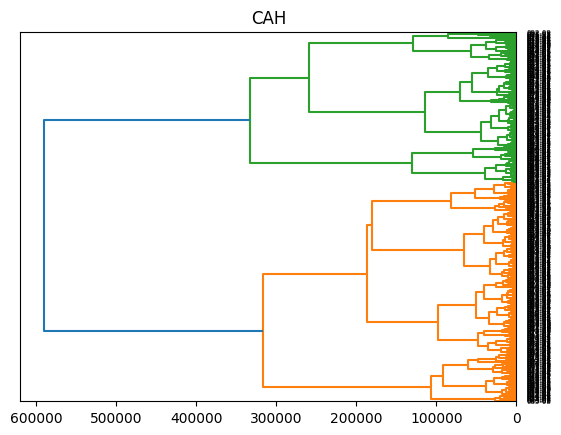

In [46]:
# affichage du dendrogramme
plt.title("CAH")
dendrogram(
    Z,
    # p = 7,
    labels=df_nona["circo"].values,
    orientation="left",
)
plt.show()

La fonction linkage sort un array avec une ligne par division de la matrice en clusters. 
- la première colonne correspond au numéro du cluster qui sera regroupé
- la deuxième colonne correspond au deuxième numéro du cluster regroupé
- la 3ème colonne correspond à la distance entre clusters
- la dernière colonne correspond au nombre d'informations originelles contenues dans le nouveau cluster.

In [47]:
linkage(df_normalise, method="ward", metric="euclidean")

array([[ 225.        ,  226.        ,    3.0230305 ,    2.        ],
       [ 445.        ,  446.        ,    3.02618165,    2.        ],
       [ 422.        ,  508.        ,    3.03533005,    2.        ],
       ...,
       [1066.        , 1072.        ,   97.23258263,  365.        ],
       [1071.        , 1073.        ,  114.03688449,  174.        ],
       [1074.        , 1075.        ,  169.70178866,  539.        ]])

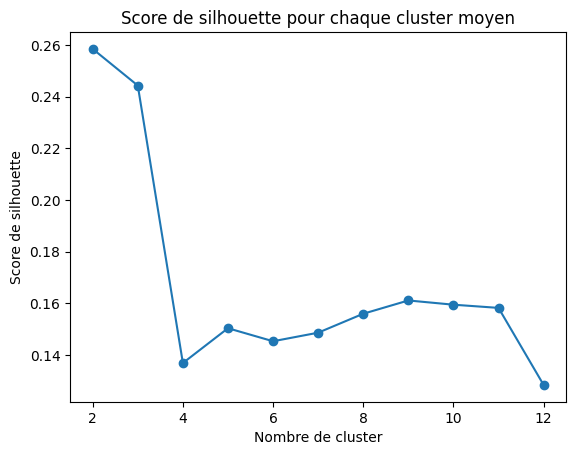

In [31]:
max_clusters = 12
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    clusters = fcluster(
        linkage(df_normalise, method="ward", metric="euclidean"),
        num_clusters,
        criterion="maxclust",
    )
    silhouette_avg = silhouette_score(df_normalise, clusters)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker="o")
plt.title("Score de silhouette pour chaque cluster moyen")
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.show()

In [43]:
# découpage à la hauteur t = 7 ==> identifiants de 4 groupes obtenus
clusters = fcluster(Z, 3, criterion="maxclust")
df_nona["clusters"] = clusters

<Axes: >

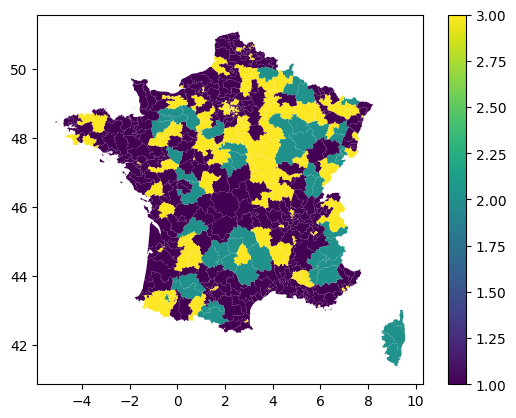

In [44]:
gdf_cluster = gdf_circo.merge(df_nona, left_on="ref", right_on="circo")
gdf_cluster.plot(column="clusters", legend=True)

In [45]:
df_nona.groupby("clusters").mean()

/tmp/ipykernel_535763/2254423425.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_nona.groupby('clusters').mean()


Inscrit_22   pop_légal_19   pop_légal_13  tvar_pop  pop_pole_aav  \
clusters                                                                       
1         91710.821875  130409.018750  126405.803125  0.501563     45.511875   
2         65073.250000   87434.153846   88181.307692 -0.138462     33.103846   
3         75604.916168  112690.455090  111751.976048  0.136527     63.944311   

          pop_cour_aav  pop_horsaav    pop_urb  pop_rur_periu  \
clusters                                                        
1            48.095000     6.388438  65.823125      21.564687   
2            49.855769    17.038462  34.119231      24.378846   
3            30.215569     5.840719  73.561677      14.721557   

          pop_rur_non_periu  ...       PPAT     PPSOC     PIMPOT  acc_ecole  \
clusters                     ...                                              
1                 12.607500  ...   9.167813  6.403750 -16.247813  96.900625   
2                 41.503846  ...   9.538462  6.157692 -14.850000  85.848077   
3                 11.719760  ...  10.511976  5.592814 -18.985030  95.666467   

          acc_college  acc_lycee  acc_medecin  acc_dentiste  acc_pharmacie  \
clusters                                                                     
1           63.935625  48.079687    83.890937     76.209688      82.003437   
2           45.167308  32.178846    64.363462     53.067308      63.786538   
3           73.079042  61.696407    84.658683     79.801198      84.118563   

          part_eloig  
clusters              
1           9.637812  
2          32.848077  
3           9.902994  

[3 rows x 122 columns]

# Export de l'ensemble des classifications

In [128]:
df_stock_cluster.to_csv(
    "resultats_clusterings.csv", index=False, index_label="Nom de la circonscription"
)